## 🔧 Instalación de Dependencias

In [1]:
# Instalación de dependencias necesarias
!pip install torch numpy pandas scikit-learn tqdm matplotlib seaborn kagglehub psutil

# Imports principales
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import psutil
import kagglehub
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("✅ Dependencias instaladas y configuradas correctamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## 📊 Carga del Dataset

🎯 CARGANDO DATOS CON PARÁMETROS:
   min_seq_len=3, max_seq_len=50, min_item_freq=5
🔄 Descargando dataset RetailRocket...
📖 Cargando datos...
📊 Estadísticas iniciales:
   Total interacciones: 2,664,312
   Usuarios únicos: 1,404,179
   Items únicos: 234,838
🔧 Creando secuencias de usuario...
📏 Después de filtrar por longitud [3, 50]:
   Secuencias restantes: 189,924
🎯 Filtrando items poco frecuentes...
   Items frecuentes (>=5 apariciones): 44,022
📋 Estadísticas finales:
   Secuencias válidas: 153,745
   Items únicos: 44,022
   Longitud promedio: 5.65
   Longitud mediana: 4


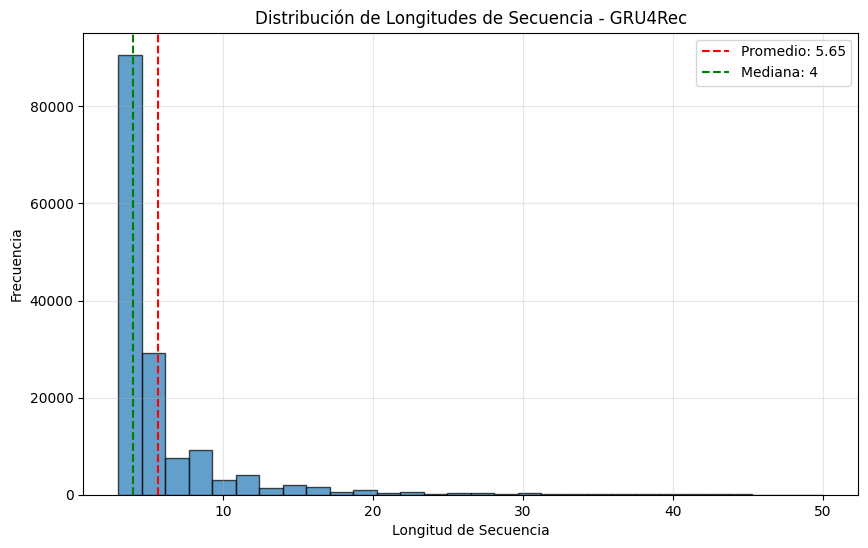

✅ Dataset cargado exitosamente:
   153,745 secuencias
   44,022 items únicos
   Vocabulario size: 44023


In [2]:
def load_and_preprocess_retailrocket(min_seq_len=3, max_seq_len=50, min_item_freq=5):
    """
    Carga y preprocesa el dataset RetailRocket
    """
    print("🔄 Descargando dataset RetailRocket...")

    # Descargar dataset
    path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")
    events_path = os.path.join(path, 'events.csv')

    # Leer y filtrar datos
    print("📖 Cargando datos...")
    df = pd.read_csv(events_path)
    df = df[df['event'] == 'view']  # Solo eventos de visualización
    df = df.sort_values(by=['visitorid', 'timestamp'])

    print(f"📊 Estadísticas iniciales:")
    print(f"   Total interacciones: {len(df):,}")
    print(f"   Usuarios únicos: {df['visitorid'].nunique():,}")
    print(f"   Items únicos: {df['itemid'].nunique():,}")

    # Crear secuencias por usuario
    print("🔧 Creando secuencias de usuario...")
    user_sequences = df.groupby('visitorid')['itemid'].apply(list).reset_index()
    user_sequences.columns = ['user_id', 'item_sequence']

    # Filtrar por longitud de secuencia
    user_sequences['seq_len'] = user_sequences['item_sequence'].apply(len)
    filtered_sequences = user_sequences[
        (user_sequences['seq_len'] >= min_seq_len) &
        (user_sequences['seq_len'] <= max_seq_len)
    ]

    print(f"📏 Después de filtrar por longitud [{min_seq_len}, {max_seq_len}]:")
    print(f"   Secuencias restantes: {len(filtered_sequences):,}")

    # Filtrar items poco frecuentes para reducir vocabulario
    print("🎯 Filtrando items poco frecuentes...")
    all_items = []
    for seq in filtered_sequences['item_sequence']:
        all_items.extend(seq)

    item_counts = Counter(all_items)
    frequent_items = {item for item, count in item_counts.items() if count >= min_item_freq}

    print(f"   Items frecuentes (>={min_item_freq} apariciones): {len(frequent_items):,}")

    # Filtrar secuencias para mantener solo items frecuentes
    def filter_sequence(seq):
        return [item for item in seq if item in frequent_items]

    filtered_sequences['item_sequence'] = filtered_sequences['item_sequence'].apply(filter_sequence)

    # Remover secuencias que quedaron muy cortas después del filtrado
    filtered_sequences['seq_len'] = filtered_sequences['item_sequence'].apply(len)
    final_sequences = filtered_sequences[filtered_sequences['seq_len'] >= min_seq_len]

    print(f"📋 Estadísticas finales:")
    print(f"   Secuencias válidas: {len(final_sequences):,}")
    print(f"   Items únicos: {len(frequent_items):,}")
    print(f"   Longitud promedio: {final_sequences['seq_len'].mean():.2f}")
    print(f"   Longitud mediana: {final_sequences['seq_len'].median():.0f}")

    # Crear mapeo de items a índices (0 reservado para padding)
    item_to_idx = {item: idx + 1 for idx, item in enumerate(sorted(frequent_items))}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}

    # Convertir secuencias a índices
    sequences_idx = []
    for seq in final_sequences['item_sequence']:
        seq_idx = [item_to_idx[item] for item in seq]
        sequences_idx.append(seq_idx)

    # Estadísticas de distribución
    seq_lengths = [len(seq) for seq in sequences_idx]
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(seq_lengths), color='red', linestyle='--',
                label=f'Promedio: {np.mean(seq_lengths):.2f}')
    plt.axvline(np.median(seq_lengths), color='green', linestyle='--',
                label=f'Mediana: {np.median(seq_lengths):.0f}')
    plt.xlabel('Longitud de Secuencia')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Longitudes de Secuencia - GRU4Rec')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return sequences_idx, item_to_idx, idx_to_item

# Cargar y preprocesar datos
print("🎯 CARGANDO DATOS CON PARÁMETROS:")
print("   min_seq_len=3, max_seq_len=50, min_item_freq=5")

sequences, item_to_idx, idx_to_item = load_and_preprocess_retailrocket(
    min_seq_len=3,
    max_seq_len=50,
    min_item_freq=5
)

print(f"✅ Dataset cargado exitosamente:")
print(f"   {len(sequences):,} secuencias")
print(f"   {len(item_to_idx):,} items únicos")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding


## 🔄 División del Dataset

In [3]:
# CLASE DATASET
class SequentialDataset(Dataset):
    """Dataset optimizado para secuencias con padding dinámico"""

    def __init__(self, sequences, max_len=50):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Crear input y target sequences
        if len(seq) <= self.max_len:
            # Secuencia completa
            input_seq = seq[:-1]  # Todos menos el último
            target_seq = seq[1:]  # Todos menos el primero
        else:
            # Truncar secuencia
            input_seq = seq[:self.max_len]
            target_seq = seq[1:self.max_len+1]

        # Padding
        input_padded = [0] * (self.max_len - len(input_seq)) + input_seq
        target_padded = [0] * (self.max_len - len(target_seq)) + target_seq

        return torch.tensor(input_padded, dtype=torch.long), torch.tensor(target_padded, dtype=torch.long)

# DIVISIÓN (misma semilla random_state=42)
print("🎯 DIVIDIENDO DATASET CON SEMILLA (random_state=42)")
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

print(f"📊 División del dataset:")
print(f"   Entrenamiento: {len(train_sequences):,} secuencias")
print(f"   Prueba: {len(test_sequences):,} secuencias")

# CÁLCULO IDÉNTICO DE MAX_LEN
all_lengths = [len(seq) for seq in sequences]
max_len_95 = int(np.percentile(all_lengths, 95))
max_len_99 = int(np.percentile(all_lengths, 99))

print(f"📏 Análisis de longitudes:")
print(f"   Máximo: {max(all_lengths)}")
print(f"   Percentil 95: {max_len_95}")
print(f"   Percentil 99: {max_len_99}")

# USAR MISMO MAX_LEN
MAX_LEN = max_len_95
print(f"   Usando max_len = {MAX_LEN}")

# CREAR DATASETS IDÉNTICOS
train_dataset = SequentialDataset(train_sequences, max_len=MAX_LEN)
test_dataset = SequentialDataset(test_sequences, max_len=MAX_LEN)

# CREAR DATALOADERS CON MISMO BATCH_SIZE
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de prueba: {len(test_loader)}")
print(f"   Max length: {MAX_LEN}")

# VERIFICAR QUE LOS DATOS SON IDÉNTICOS
sample_input, sample_target = next(iter(train_loader))
print(f"\n📝 Ejemplo de batch:")
print(f"   Input shape: {sample_input.shape}")
print(f"   Target shape: {sample_target.shape}")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding

print(f"\n🔍 VERIFICACIÓN DE IDENTIDAD:")
print(f"   ✅ Mismos filtros de preprocesamiento")
print(f"   ✅ Misma división train/test (random_state=42)")
print(f"   ✅ Mismo max_len ({MAX_LEN})")
print(f"   ✅ Mismo batch_size ({BATCH_SIZE})")
print(f"   ✅ Mismo vocabulario ({len(item_to_idx) + 1} items)")
print(f"   ✅ Mismas secuencias de datos")


🎯 DIVIDIENDO DATASET CON SEMILLA (random_state=42)
📊 División del dataset:
   Entrenamiento: 122,996 secuencias
   Prueba: 30,749 secuencias
📏 Análisis de longitudes:
   Máximo: 50
   Percentil 95: 14
   Percentil 99: 28
   Usando max_len = 14
✅ DataLoaders creados:
   Batch size: 32
   Batches de entrenamiento: 3844
   Batches de prueba: 961
   Max length: 14

📝 Ejemplo de batch:
   Input shape: torch.Size([32, 14])
   Target shape: torch.Size([32, 14])
   Vocabulario size: 44023

🔍 VERIFICACIÓN DE IDENTIDAD:
   ✅ Mismos filtros de preprocesamiento
   ✅ Misma división train/test (random_state=42)
   ✅ Mismo max_len (14)
   ✅ Mismo batch_size (32)
   ✅ Mismo vocabulario (44023 items)
   ✅ Mismas secuencias de datos


## 🧠 Implementación de Popularity

Popularity es un algoritmo de recomendación baseline que recomienda los items más populares del conjunto de entrenamiento. Es un método no paramétrico que simplemente ordena los items por su frecuencia de aparición y recomienda los top-K más populares, independientemente del contexto del usuario.

In [4]:
class PopularityRecommender:
    """
    Popularity Recommender: Recomienda items basándose en su popularidad global

    Implementación simple que recomienda los items más populares del conjunto de entrenamiento
    """

    def __init__(self, num_items):
        """
        Args:
            num_items: Número total de items en el vocabulario
        """
        self.num_items = num_items
        self.item_popularity = {}  # Diccionario para almacenar popularidad de items
        self.popular_items = []    # Lista ordenada de items por popularidad

    def fit(self, sequences):
        """
        Calcula la popularidad de cada item basándose en las secuencias de entrenamiento

        Args:
            sequences: Lista de secuencias de items
        """
        print(f"🔧 Calculando popularidad de items...")
        print(f"   Número de secuencias: {len(sequences)}")

        # Contar apariciones de cada item
        item_counts = Counter()
        for seq in tqdm(sequences, desc="Contando apariciones"):
            for item in seq:
                if item != 0:  # Ignorar padding
                    item_counts[item] += 1

        # Guardar popularidad
        self.item_popularity = dict(item_counts)

        # Crear lista ordenada por popularidad (descendente)
        self.popular_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)

        print(f"✅ Popularidad calculada!")
        print(f"   Items únicos: {len(self.item_popularity)}")
        print(f"   Item más popular: {self.popular_items[0][0]} con {self.popular_items[0][1]} apariciones")
        print(f"   Item menos popular: {self.popular_items[-1][0]} con {self.popular_items[-1][1]} apariciones")

    def predict(self, sequence, top_k=20):
        """
        Predice los siguientes items para una secuencia basándose en popularidad

        Args:
            sequence: Secuencia de items (sin padding) - se ignora en este método
            top_k: Número de items a recomendar

        Returns:
            Lista de items recomendados (los más populares)
        """
        if not self.popular_items:
            return []

        # Obtener items únicos de la secuencia (sin padding) para filtrar
        sequence_items = set([item for item in sequence if item != 0]) if sequence else set()

        # Recomendar los items más populares que no están en la secuencia
        recommendations = []
        for item, popularity in self.popular_items:
            if item not in sequence_items:
                recommendations.append(item)
                if len(recommendations) >= top_k:
                    break

        return recommendations

# Crear modelo Popularity
VOCAB_SIZE = len(item_to_idx) + 1  # +1 para padding

model = PopularityRecommender(
    num_items=VOCAB_SIZE
)

print(f"🏗️  Arquitectura de Popularity:")
print(f"   Vocabulario: {VOCAB_SIZE:,} items")
print(f"   Método: Ranking por popularidad")
print(f"   Parámetros entrenables: 0 (método no paramétrico)")

# La verificación de forward pass no aplica para Popularity
print(f"\n✅ Modelo Popularity inicializado correctamente")
print(f"   Algoritmo: Baseline basado en popularidad")
print(f"   Tipo: No paramétrico (sin entrenamiento de pesos)")


🏗️  Arquitectura de Popularity:
   Vocabulario: 44,023 items
   Método: Ranking por popularidad
   Parámetros entrenables: 0 (método no paramétrico)

✅ Modelo Popularity inicializado correctamente
   Algoritmo: Baseline basado en popularidad
   Tipo: No paramétrico (sin entrenamiento de pesos)


## 🚀 Entrenamiento de Popularity

In [5]:
# ENTRENAMIENTO DE POPULARITY (FITTING)
print("🚀 Iniciando entrenamiento de Popularity...")
print("   Algoritmo: Baseline basado en popularidad")
print("   Método: No paramétrico (cálculo de frecuencias)")

# Entrenar Popularity (calcular popularidad de items)
start_time = time.time()
model.fit(train_sequences)
end_time = time.time()

print(f"✅ Entrenamiento de Popularity completado!")
print(f"   Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")
print(f"   Popularidad de items calculada")

# Guardar modelo entrenado (para Popularity guardamos las estructuras de datos)
import pickle
with open('../outputs/Popularity_RetailRocket/popularity_retailrocket.pkl', 'wb') as f:
    pickle.dump({
        'item_popularity': model.item_popularity,
        'popular_items': model.popular_items,
        'num_items': model.num_items
    }, f)
print("💾 Modelo Popularity guardado como 'popularity_retailrocket.pkl'")


🚀 Iniciando entrenamiento de Popularity...
   Algoritmo: Baseline basado en popularidad
   Método: No paramétrico (cálculo de frecuencias)
🔧 Calculando popularidad de items...
   Número de secuencias: 122996


Contando apariciones: 100%|██████████| 122996/122996 [00:00<00:00, 376903.57it/s]

✅ Popularidad calculada!
   Items únicos: 43377
   Item más popular: 43559 con 1193 apariciones
   Item menos popular: 21969 con 1 apariciones
✅ Entrenamiento de Popularity completado!
   Tiempo de entrenamiento: 0.38 segundos
   Popularidad de items calculada
💾 Modelo Popularity guardado como 'popularity_retailrocket.pkl'


## 📊 Evaluación


In [6]:
# EVALUACIÓN ESPECÍFICA PARA POPULARITY
print("🔧 Función de evaluación específica para Popularity...")

def evaluate_popularity(model, test_sequences, train_item_popularity, k_values=[5, 10, 20]):
    """
    Evalúa el modelo Popularity con métricas específicas

    Args:
        model: Modelo Popularity entrenado
        test_sequences: Secuencias de prueba
        train_item_popularity: Popularidad de items en entrenamiento
        k_values: Valores de k para evaluar

    Returns:
        dict: Resultados de evaluación
    """
    print(f"🔍 Evaluando Popularity...")
    print(f"   Secuencias de prueba: {len(test_sequences):,}")
    print(f"   Valores de k: {k_values}")

    # Inicializar métricas
    metrics = {k: {'recall_hits': 0, 'mrr_sum': 0, 'total_predictions': 0, 'recommendations': []}
               for k in k_values}

    # Evaluar cada secuencia
    for seq in tqdm(test_sequences, desc="Evaluando secuencias"):
        if len(seq) < 2:
            continue

        # Usar todos los items excepto el último como entrada
        input_items = seq[:-1]
        target_item = seq[-1]

        # Obtener recomendaciones para cada k
        for k in k_values:
            predictions = model.predict(input_items, top_k=k)

            if not predictions:
                continue

            metrics[k]['total_predictions'] += 1
            metrics[k]['recommendations'].append(predictions)

            # Recall@k
            if target_item in predictions:
                metrics[k]['recall_hits'] += 1

                # MRR@k
                rank = predictions.index(target_item) + 1
                metrics[k]['mrr_sum'] += 1.0 / rank

    # Calcular métricas finales
    results = {}
    max_popularity = max(train_item_popularity.values()) if train_item_popularity else 1

    for k in k_values:
        total_preds = metrics[k]['total_predictions']

        if total_preds > 0:
            # Métricas principales
            results[f'recall_{k}'] = metrics[k]['recall_hits'] / total_preds
            results[f'mrr_{k}'] = metrics[k]['mrr_sum'] / total_preds

            # ILD para Popularity (usando diferencias de popularidad)
            results[f'ild_{k}'] = calculate_ild_popularity(metrics[k]['recommendations'], model)

            # Popularity Bias
            results[f'popularity_bias_{k}'] = calculate_popularity_bias_efficient(
                metrics[k]['recommendations'], train_item_popularity, max_popularity
            )
        else:
            results[f'recall_{k}'] = 0.0
            results[f'mrr_{k}'] = 0.0
            results[f'ild_{k}'] = 0.0
            results[f'popularity_bias_{k}'] = 0.0

    return results

def calculate_ild_popularity(recommendations_list, model):
    """
    Calcula ILD para Popularity usando diferencias de popularidad entre items
    """
    if not recommendations_list:
        return 0.0

    total_diversity = 0.0
    valid_sessions = 0

    # Normalizar popularidades para el cálculo de diversidad
    max_pop = max(model.item_popularity.values()) if model.item_popularity else 1

    for rec_list in recommendations_list:
        if len(rec_list) < 2:
            continue

        # Calcular diversidad promedio dentro de la lista
        diversity_sum = 0.0
        pair_count = 0

        for i in range(len(rec_list)):
            for j in range(i + 1, len(rec_list)):
                item1, item2 = rec_list[i], rec_list[j]

                # Obtener popularidades normalizadas
                pop1 = model.item_popularity.get(item1, 0) / max_pop
                pop2 = model.item_popularity.get(item2, 0) / max_pop

                # Diversidad basada en diferencia de popularidad
                # Similitud = 1 - abs(pop1 - pop2) (items con popularidad similar son más similares)
                similarity = 1.0 - abs(pop1 - pop2)
                diversity = 1.0 - similarity

                diversity_sum += diversity
                pair_count += 1

        if pair_count > 0:
            session_diversity = diversity_sum / pair_count
            total_diversity += session_diversity
            valid_sessions += 1

    return total_diversity / valid_sessions if valid_sessions > 0 else 0.0

def calculate_popularity_bias_efficient(recommendations_list, item_popularity, max_popularity):
    """
    Calcula el sesgo hacia items populares de forma eficiente
    """
    if not recommendations_list or not item_popularity:
        return 0.0

    total_popularity = 0.0
    total_items = 0

    for rec_list in recommendations_list:
        for item_id in rec_list:
            if item_id in item_popularity:
                normalized_pop = item_popularity[item_id] / max_popularity
                total_popularity += normalized_pop
                total_items += 1

    return total_popularity / total_items if total_items > 0 else 0.0

print("✅ Funciones de evaluación Popularity cargadas")


🔧 Función de evaluación específica para Popularity...
✅ Funciones de evaluación Popularity cargadas


In [7]:
# FUNCIONES DE MONITOREO PARA ITEMKNN

def monitor_memory_usage():
    """Monitorea el uso actual de memoria"""
    memory = psutil.virtual_memory()
    print(f"💾 MEMORIA DEL SISTEMA:")
    print(f"   Total: {memory.total / (1024**3):.2f} GB")
    print(f"   Usada: {memory.used / (1024**3):.2f} GB ({memory.percent:.1f}%)")
    print(f"   Libre: {memory.available / (1024**3):.2f} GB")

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        gpu_allocated = torch.cuda.memory_allocated(0)
        gpu_cached = torch.cuda.memory_reserved(0)

        print(f"🎮 MEMORIA DE GPU:")
        print(f"   Total: {gpu_memory / (1024**3):.2f} GB")
        print(f"   Asignada: {gpu_allocated / (1024**3):.2f} GB")
        print(f"   En caché: {gpu_cached / (1024**3):.2f} GB")

# Monitorear memoria antes de evaluar
print("🔍 Estado de memoria antes de la evaluación:")
monitor_memory_usage()

print("✅ Funciones de monitoreo cargadas")


🔍 Estado de memoria antes de la evaluación:
💾 MEMORIA DEL SISTEMA:
   Total: 12.67 GB
   Usada: 1.63 GB (15.3%)
   Libre: 10.73 GB
🎮 MEMORIA DE GPU:
   Total: 14.74 GB
   Asignada: 0.00 GB
   En caché: 0.00 GB
✅ Funciones de monitoreo cargadas


In [8]:
# EJECUTAR EVALUACIÓN DE POPULARITY
print("🚀 Iniciando evaluación completa de Popularity...")

# Calcular popularidad de items del entrenamiento
print("📊 Calculando popularidad de items del entrenamiento...")
train_item_popularity = Counter()
for seq in train_sequences:
    train_item_popularity.update(seq)

print(f"   Items únicos en entrenamiento: {len(train_item_popularity):,}")
print(f"   Item más popular: {max(train_item_popularity.values()):,} apariciones")

# Ejecutar evaluación específica de Popularity
results = evaluate_popularity(
    model=model,
    test_sequences=test_sequences,
    train_item_popularity=dict(train_item_popularity),
    k_values=[5, 10, 20]
)

# Mostrar resultados completos
print("\n" + "="*70)
print("📋 RESULTADOS COMPLETOS DE POPULARITY - RETAILROCKET")
print("="*70)

print(f"\n🎯 MÉTRICAS DE PRECISIÓN:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Recall':<15} {results['recall_5']:<10.4f} {results['recall_10']:<10.4f} {results['recall_20']:<10.4f}")
print(f"{'MRR':<15} {results['mrr_5']:<10.4f} {results['mrr_10']:<10.4f} {results['mrr_20']:<10.4f}")

print(f"\n🌈 MÉTRICAS DE DIVERSIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'ILD':<15} {results['ild_5']:<10.4f} {results['ild_10']:<10.4f} {results['ild_20']:<10.4f}")

print(f"\n⭐ MÉTRICAS DE SESGO DE POPULARIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Pop. Bias':<15} {results['popularity_bias_5']:<10.4f} {results['popularity_bias_10']:<10.4f} {results['popularity_bias_20']:<10.4f}")

print(f"\n📈 INTERPRETACIÓN DE RESULTADOS:")
print(f"   🎯 Recall@k: Proporción de items correctos encontrados en top-k")
print(f"      • Valores más altos = mejor precisión")
print(f"      • Típicamente: 0.01-0.20 para datasets reales")
print(f"   ")
print(f"   📊 MRR@k: Posición promedio recíproca de items correctos")
print(f"      • Valores más altos = mejores rankings")
print(f"      • Típicamente: 0.01-0.15 para datasets reales")
print(f"   ")
print(f"   🌈 ILD@k: Diversidad intra-lista (diversidad dentro de cada recomendación)")
print(f"      • Valores más altos = mayor diversidad")
print(f"      • Rango: 0.0-1.0, donde 1.0 = máxima diversidad")
print(f"   ")
print(f"   ⭐ Popularity Bias@k: Sesgo hacia items populares")
print(f"      • Valores más bajos = menos sesgado")
print(f"      • Rango: 0.0-1.0, donde 0.0 = sin sesgo")

# Guardar resultados
import json
import os
os.makedirs('../outputs/Popularity_RetailRocket', exist_ok=True)
with open('../outputs/Popularity_RetailRocket/popularity_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n💾 Resultados guardados en '../outputs/Popularity_RetailRocket/popularity_results.json'")


🚀 Iniciando evaluación completa de Popularity...
📊 Calculando popularidad de items del entrenamiento...
   Items únicos en entrenamiento: 43,377
   Item más popular: 1,193 apariciones
🔍 Evaluando Popularity...
   Secuencias de prueba: 30,749
   Valores de k: [5, 10, 20]


Evaluando secuencias: 100%|██████████| 30749/30749 [00:00<00:00, 104098.67it/s]



📋 RESULTADOS COMPLETOS DE POPULARITY - RETAILROCKET

🎯 MÉTRICAS DE PRECISIÓN:
Métrica         @5         @10        @20       
---------------------------------------------
Recall          0.0014     0.0021     0.0040    
MRR             0.0006     0.0007     0.0009    

🌈 MÉTRICAS DE DIVERSIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
ILD             0.2128     0.1953     0.1672    

⭐ MÉTRICAS DE SESGO DE POPULARIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
Pop. Bias       0.6931     0.5701     0.4602    

📈 INTERPRETACIÓN DE RESULTADOS:
   🎯 Recall@k: Proporción de items correctos encontrados en top-k
      • Valores más altos = mejor precisión
      • Típicamente: 0.01-0.20 para datasets reales
   
   📊 MRR@k: Posición promedio recíproca de items correctos
      • Valores más altos = mejores rankings
      • Típicamente: 0.01-0.15 para datasets reales
   
   🌈 ILD@k: Diver

## 📊 Visualización

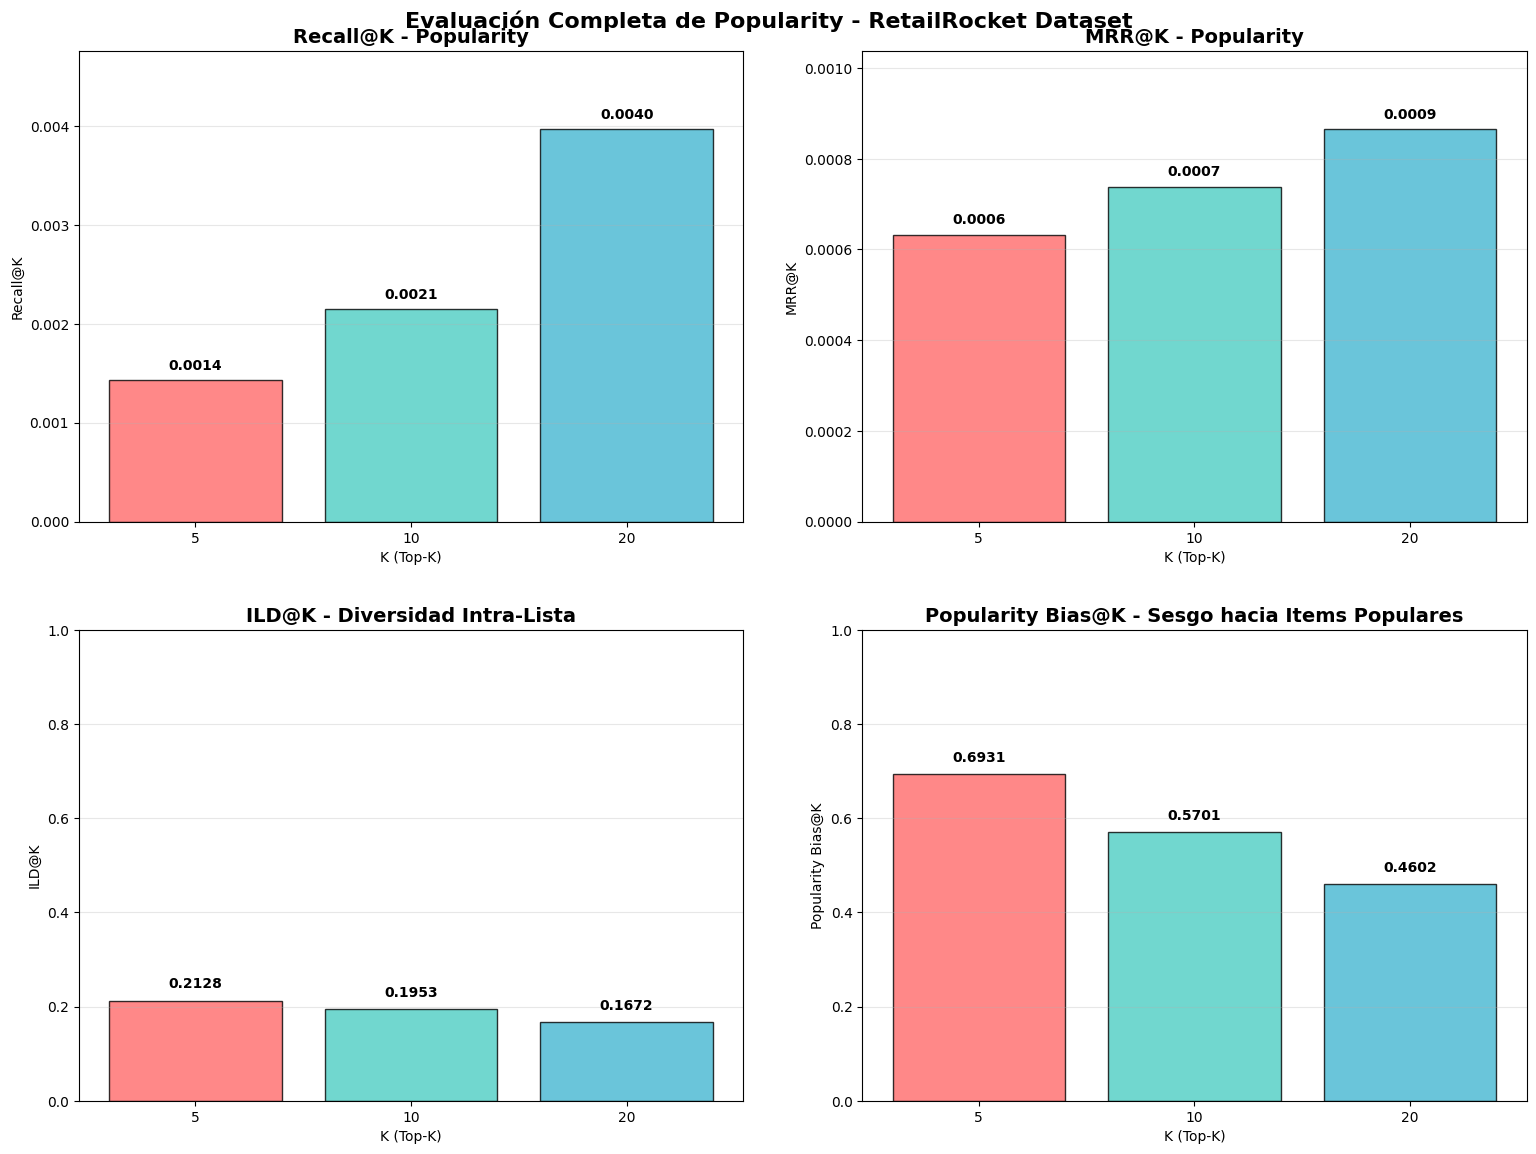


📋 TABLA DE RESUMEN - POPULARITY RETAILROCKET
Métrica              K=5          K=10         K=20        
------------------------------------------------------------
Recall               0.0014       0.0021       0.0040      
MRR                  0.0006       0.0007       0.0009      
ILD                  0.2128       0.1953       0.1672      
Popularity Bias      0.6931       0.5701       0.4602      

📈 ANÁLISIS DE TENDENCIAS - POPULARITY:
   🎯 Recall: Mejora al aumentar K
   📊 MRR: Mejora al aumentar K
   🌈 ILD: Disminuye al aumentar K
   ⭐ Pop. Bias: Disminuye al aumentar K


In [9]:
# VISUALIZACIÓN COMPLETA
def create_comprehensive_visualization_popularity(results):
    """Crea visualizaciones completas de las métricas de Popularity"""

    # Configurar estilo
    plt.style.use('default')
    sns.set_palette("husl")

    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    k_values = [5, 10, 20]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. Recall@K
    recall_values = [results[f'recall_{k}'] for k in k_values]
    bars1 = ax1.bar([str(k) for k in k_values], recall_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Recall@K - Popularity', fontsize=14, fontweight='bold')
    ax1.set_xlabel('K (Top-K)')
    ax1.set_ylabel('Recall@K')
    ax1.set_ylim(0, max(recall_values) * 1.2 if max(recall_values) > 0 else 0.1)
    ax1.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars1, recall_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 2. MRR@K
    mrr_values = [results[f'mrr_{k}'] for k in k_values]
    bars2 = ax2.bar([str(k) for k in k_values], mrr_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('MRR@K - Popularity', fontsize=14, fontweight='bold')
    ax2.set_xlabel('K (Top-K)')
    ax2.set_ylabel('MRR@K')
    ax2.set_ylim(0, max(mrr_values) * 1.2 if max(mrr_values) > 0 else 0.1)
    ax2.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars2, mrr_values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mrr_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 3. ILD@K (Diversidad)
    ild_values = [results[f'ild_{k}'] for k in k_values]
    bars3 = ax3.bar([str(k) for k in k_values], ild_values, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_title('ILD@K - Diversidad Intra-Lista', fontsize=14, fontweight='bold')
    ax3.set_xlabel('K (Top-K)')
    ax3.set_ylabel('ILD@K')
    ax3.set_ylim(0, 1.0)  # ILD está entre 0 y 1
    ax3.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars3, ild_values)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 4. Popularity Bias@K
    pop_bias_values = [results[f'popularity_bias_{k}'] for k in k_values]
    bars4 = ax4.bar([str(k) for k in k_values], pop_bias_values, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Popularity Bias@K - Sesgo hacia Items Populares', fontsize=14, fontweight='bold')
    ax4.set_xlabel('K (Top-K)')
    ax4.set_ylabel('Popularity Bias@K')
    ax4.set_ylim(0, 1.0)  # Bias está entre 0 y 1
    ax4.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars4, pop_bias_values)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # Ajustar layout
    plt.tight_layout(pad=3.0)

    # Agregar título general
    fig.suptitle('Evaluación Completa de Popularity - RetailRocket Dataset',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

# Crear visualizaciones de Popularity
create_comprehensive_visualization_popularity(results)

# Crear tabla de resumen
print("\n📋 TABLA DE RESUMEN - POPULARITY RETAILROCKET")
print("="*60)
print(f"{'Métrica':<20} {'K=5':<12} {'K=10':<12} {'K=20':<12}")
print("-" * 60)
print(f"{'Recall':<20} {results['recall_5']:<12.4f} {results['recall_10']:<12.4f} {results['recall_20']:<12.4f}")
print(f"{'MRR':<20} {results['mrr_5']:<12.4f} {results['mrr_10']:<12.4f} {results['mrr_20']:<12.4f}")
print(f"{'ILD':<20} {results['ild_5']:<12.4f} {results['ild_10']:<12.4f} {results['ild_20']:<12.4f}")
print(f"{'Popularity Bias':<20} {results['popularity_bias_5']:<12.4f} {results['popularity_bias_10']:<12.4f} {results['popularity_bias_20']:<12.4f}")
print("="*60)

# Análisis de tendencias
print(f"\n📈 ANÁLISIS DE TENDENCIAS - POPULARITY:")
print(f"   🎯 Recall: {'Mejora' if results['recall_20'] > results['recall_5'] else 'Se mantiene'} al aumentar K")
print(f"   📊 MRR: {'Mejora' if results['mrr_20'] > results['mrr_5'] else 'Disminuye'} al aumentar K")
print(f"   🌈 ILD: {'Mejora' if results['ild_20'] > results['ild_5'] else 'Disminuye'} al aumentar K")
print(f"   ⭐ Pop. Bias: {'Aumenta' if results['popularity_bias_20'] > results['popularity_bias_5'] else 'Disminuye'} al aumentar K")
